# Experiments on fully connected layers

/!\ Draft-only /!\

In [15]:
import copy

import torch

import torch.optim as optim
import torch.nn as nn

import torchvision

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from datasets import CustomDataset
from models import FCNet
from helpers import SoftHingeLoss, SoftPlus

In [16]:
batch_size = 128  # training batch size

classes_name = (
    "T-shirt/Top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle Boot"
)

n_samples_training = 10000

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))
])

# data are assumed to be already downloaded in the root folder
# otherwise, specify path and set download=True
trainset = torchvision.datasets.FashionMNIST(
    '/Users/raphaelbordas/Code/sandbox_deep_learning/data',
    train=True,
    download=False,
    transform=transform
)
testset = torchvision.datasets.FashionMNIST(
    '/Users/raphaelbordas/Code/sandbox_deep_learning/data',
    train=False,
    download=False,
    transform=transform
)
dataset = list(trainset) + list(testset)
classes = sorted({y for x, y in dataset})

torch.manual_seed(42)
new_idx = torch.randperm(len(dataset))
dataset = [dataset[i] for i in new_idx]
x = torch.stack([x for x, y in dataset])
y = torch.tensor([y for x, y in dataset])

# transform y for binary classification
# y in {-1, 1} instead of {0, 1, ..., 9}
# y = (2 * (torch.arange(len(y)) % 2) - 1).type(x.dtype)
y = (2 * (y % 2) - 1).type(x.dtype)
# dict to track if the new class is a positive or negative class
class_sign = {i: sign for i, sign in zip(classes, y.unique())}

x_train = x[:n_samples_training]
y_train = y[:n_samples_training]
x_test = x[n_samples_training:]
y_test = y[n_samples_training:]

trainloader = torch.utils.data.DataLoader(
    CustomDataset(x_train, y_train),
    batch_size=batch_size,
)
testloader = torch.utils.data.DataLoader(
    CustomDataset(x_test, y_test),
    batch_size=batch_size,
)

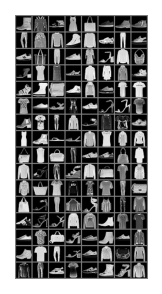

In [17]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(4, 2), dpi=150)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    plt.tight_layout()
    plt.show()


# get batch_size random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

In [18]:
hh = np.logspace(2, np.log10(1500), 12, dtype=int)
hh

array([ 100,  127,  163,  209,  267,  342,  438,  560,  716,  916, 1172,
       1500])

In [25]:
from ntk_freeze import *

mps_device = torch.device("mps")
net = FCNet(28 * 28, h=100, L=3, activation=SoftPlus(), device="mps", copy_initial_params=False)
net.to(mps_device)

optimizer = optim.SGD(net.parameters(), lr=0.01)
criterion = SoftHingeLoss(alpha=1)
f_omega0 = copy.deepcopy(net)
f_omega0.eval()

lazy_train(
    net,
    trainloader,
    criterion,
    lr=0.01,
    device=mps_device,
    epochs=100
)


AttributeError: 'FCNet' object has no attribute 'initial_params'

In [26]:
import pandas as pd
import itertools

# hh = np.logspace(2, np.log10(1500), 12, dtype=int)
# alphas = np.logspace(-4, 7, 12, dtype=float)
hh = np.array([10, 14, 19, 27, 37, 52, 72, 100, 139, 193, 268, 373, 518, 720, 1000, 1390])
alphas = 1 / np.sqrt(hh)
mps_device = torch.device("mps")

hyperparams_runs = np.stack([hh, alphas], axis=1)
results = pd.DataFrame(dict(
    h=hyperparams_runs[:, 0],
    alpha=hyperparams_runs[:, 1],
    tr_accuracy=np.zeros(hyperparams_runs.shape[0]),
    te_accuracy=np.zeros(hyperparams_runs.shape[0]),
    has_converged=np.zeros(hyperparams_runs.shape[0]),
    training_loss=np.zeros(hyperparams_runs.shape[0]),
    n_epochs=np.zeros(hyperparams_runs.shape[0]),
    L=np.zeros(hyperparams_runs.shape[0]),
    param_samle_ratio=np.zeros(hyperparams_runs.shape[0]),
    training_time=np.zeros(hyperparams_runs.shape[0]),
))

for idx, (h_, alpha_) in enumerate(hyperparams_runs):
    results.loc[idx, "h"] = h_
    results.loc[idx, "alpha"] = alpha_

    net = FCNet(28 * 28, h=int(h_), L=1, activation=SoftPlus(), copy_initial_params=False)
    net.to(mps_device)

    optimizer = optim.SGD(net.parameters(), lr=1)
    criterion = SoftHingeLoss(alpha=alpha_)
    f_omega0 = copy.deepcopy(net)
    f_omega0.eval()

    net.train()
    training_losses = []

    n_epochs = 100
    for epoch in tqdm(range(n_epochs), desc=f"Training with h = {h_}, alpha = {alpha_}", total=n_epochs, leave=True,
                      position=0):
        epoch_loss = 0.0
        num_batches = 0
        has_converged = True

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(mps_device), labels.to(mps_device)

            optimizer.zero_grad()
            with torch.no_grad():
                initial_output = f_omega0(inputs).squeeze()

            outputs = net(inputs).squeeze()
            loss = criterion(outputs - initial_output, labels)

            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            num_batches += 1

            if (alpha_ * (outputs - initial_output) * labels <= 1).any():
                has_converged = False

        # early stopping if criteria is met for all batches
        if has_converged:
            break

        avg_epoch_loss = epoch_loss / num_batches
        training_losses.append(avg_epoch_loss)

    # average loss of the last epoch
    results.loc[idx, "training_loss"] = avg_epoch_loss
    results.loc[idx, "n_epochs"] = len(training_losses)

    correct = 0
    total = 0
    for inputs, labels in trainloader:
        with torch.no_grad():
            initial_output = f_omega0(inputs.to(mps_device)).squeeze().to("cpu")
            outputs = net(inputs.to(mps_device)).squeeze().to("cpu")
        logits = outputs - initial_output
        predictions = torch.sign(logits)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)
        # has_converged.append((1 * (outputs - initial_output) * labels > 1).double())

    results.loc[idx, "tr_accuracy"] = 100 * correct / total

    correct = 0
    total = 0
    for inputs, labels in testloader:
        with torch.no_grad():
            initial_output = f_omega0(inputs.to(mps_device)).squeeze().to("cpu")
            outputs = net(inputs.to(mps_device)).squeeze().to("cpu")
        logits = outputs - initial_output
        predictions = torch.sign(logits)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

    results.loc[idx, "te_accuracy"] = 100 * correct / total

Training with h = 10.0, alpha = 0.31622776601683794:  84%|████████▎ | 251/300 [01:37<00:18,  2.59it/s]


KeyboardInterrupt: 

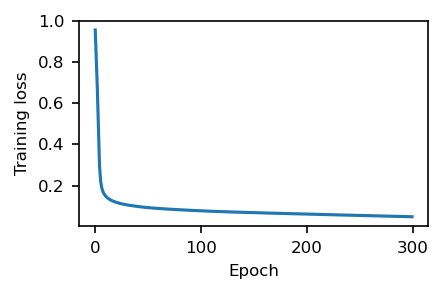

In [12]:
plt.rcParams.update({'font.size': 8})
fig = plt.figure(figsize=(3, 2), dpi=150)
plt.plot(training_losses)
plt.ylabel("Training loss")
plt.xlabel("Epoch")
fig.tight_layout()
plt.show()

In [37]:
mps_device = torch.device("mps")

net = FCNet(28 * 28, h=300, L=3, activation=SoftPlus())
net.to(mps_device)

alpha = 1

losses = []
i = 0
n_epochs = 200
lr = 0.01
optimizer = optim.SGD(net.parameters(), lr=lr)
criterion = SoftHingeLoss(alpha=alpha)
f_omega0 = copy.deepcopy(net)
f_omega0.eval()  # Set to eval mode since we won't update it

net.train()
training_losses = []

for epoch in tqdm(range(n_epochs), total=n_epochs, leave=True, position=0):
    epoch_loss = 0.0
    num_batches = 0
    has_converged = True

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(mps_device), labels.to(mps_device)

        i += 1
        optimizer.zero_grad()
        with torch.no_grad():
            initial_output = f_omega0(inputs).squeeze()

        outputs = net(inputs).squeeze()
        loss = criterion(outputs - initial_output, labels)

        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        num_batches += 1

        if (alpha * (outputs - initial_output) * labels <= 1).any():
            has_converged = False

    # early stopping if criteria is met for all batches
    if has_converged:
        print("Early stopping at Epoch", epoch + 1)
        break

    avg_epoch_loss = epoch_loss / num_batches
    training_losses.append(avg_epoch_loss)

print(f'Number of gradient steps {i}')

100%|██████████| 200/200 [02:10<00:00,  1.53it/s]

Number of gradient steps 31400


In [38]:
correct = 0
total = 0
has_converged = []
for inputs, labels in trainloader:
    with torch.no_grad():
        initial_output = f_omega0(inputs.to(mps_device)).squeeze().to("cpu")
        outputs = net(inputs.to(mps_device)).squeeze().to("cpu")
    logits = outputs - initial_output
    predictions = torch.sign(logits)
    correct += (predictions == labels).sum().item()
    total += labels.size(0)
    has_converged.append((1 * (outputs - initial_output) * labels > 1).double())

print(f'Accuracy of the network on the {total} training images: {100 * correct / total:.2f}%')
print(torch.cat(has_converged).mean().item())

Accuracy of the network on the 10000 training images: 99.79%
0.9756


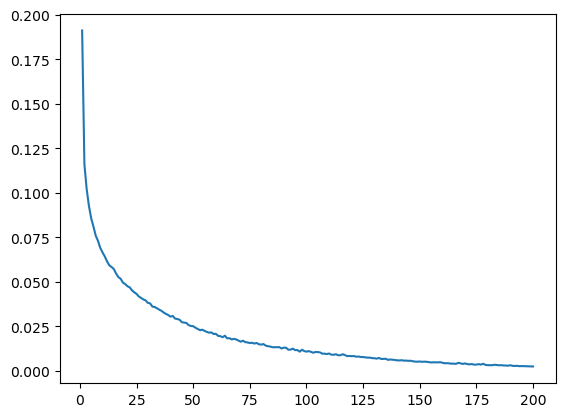

In [6]:
plt.plot(np.arange(n_epochs) + 1, training_losses)

In [9]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# plot of the parameter-to-sample ratio for h in {100, 300, 500, 1000, 1500}
num_params = count_parameters(net)
num_samples = len(CustomDataset(x_train, y_train))  # Number of training samples

ratio = num_params / num_samples
print(f"Parameter-to-sample ratio: {ratio:.2f}")

Parameter-to-sample ratio: 41.55
